In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-222/train.csv


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import nltk
import re
import string
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# load the dataset
df = pd.read_csv("/kaggle/input/fake-news-222/train.csv")
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [5]:
df['text'] = df['title'] + " " + df['text']
df = df[['text', 'label']]
df = df[df['text'].notna()]
df = df.reset_index(drop=True)
df.head()

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0
2,Why the Truth Might Get You Fired Why the Trut...,1
3,15 Civilians Killed In Single US Airstrike Hav...,1
4,Iranian woman jailed for fictional unpublished...,1


In [7]:
df.isna().sum()

text     0
label    0
dtype: int64

In [8]:
new_df=df.copy()

In [10]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [11]:
new_df['text']=new_df['text'].apply(lambda x:review_cleaning(x))
new_df.head()

,text,label
0,house dem aide we didn’t even see comey’s lett...,1
1,flynn hillary clinton big woman on campus bre...,0
2,why the truth might get you fired why the trut...,1
3,civilians killed in single us airstrike have ...,1
4,iranian woman jailed for fictional unpublished...,1


In [12]:
stop = stopwords.words('english')
new_df['text'] = new_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
new_df.head()

,text,label
0,house dem aide didn’t even see comey’s letter ...,1
1,flynn hillary clinton big woman campus breitba...,0
2,truth might get fired truth might get fired oc...,1
3,civilians killed single us airstrike identifie...,1
4,iranian woman jailed fictional unpublished sto...,1


In [13]:
max_words = 5000
maxlen = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(new_df['text'])
sequences = tokenizer.texts_to_sequences(new_df['text'])
X = pad_sequences(sequences, maxlen=maxlen)
y = new_df['label']
y = pd.get_dummies(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CNN

In [15]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(2, activation='sigmoid'))

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          640000    
                                                                 
 conv1d (Conv1D)             (None, 96, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 681,154
Trainable params: 681,154
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
253/253 [==============================] - 42s 127ms/step - loss: 0.2866 - accuracy: 0.8725 - val_loss: 0.1276 - val_accuracy: 0.9545
Epoch 2/5
253/253 [==============================] - 12s 47ms/step - loss: 0.0862 - accuracy: 0.9698 - val_loss: 0.1188 - val_accuracy: 0.9552
Epoch 3/5
253/253 [==============================] - 6s 24ms/step - loss: 0.0341 - accuracy: 0.9915 - val_loss: 0.1282 - val_accuracy: 0.9540
Epoch 4/5
253/253 [==============================] - 7s 26ms/step - loss: 0.0099 - accuracy: 0.9989 - val_loss: 0.1436 - val_accuracy: 0.9480
Epoch 5/5
253/253 [==============================] - 4s 15ms/step - loss: 0.0026 - accuracy: 0.9999 - val_loss: 0.1551 - val_accuracy: 0.9485


In [19]:
y_pred0 = model.predict(X_test)
y_pred0 = [1 if x[1]>0.5 else 0 for x in y_pred0]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test.iloc[:,1], y_pred0))
print('Classification Report:')
print(classification_report(y_test.iloc[:,1], y_pred0))

127/127 [==============================] - 0s 2ms/step
Accuracy: 0.9487750556792873
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2089
           1       0.95      0.95      0.95      1952

    accuracy                           0.95      4041
   macro avg       0.95      0.95      0.95      4041
weighted avg       0.95      0.95      0.95      4041



In [20]:
cm_cv = confusion_matrix(y_test.iloc[:,1],y_pred0)
cm_cv

array([[1985,  104],
       [ 103, 1849]])

In [21]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

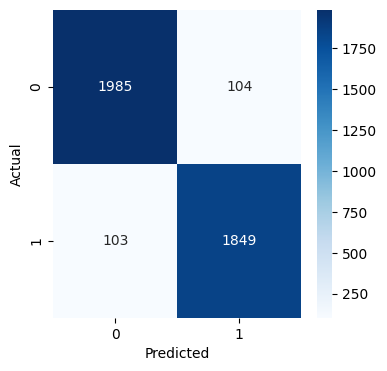

In [22]:
plt.figure(figsize = (4,4))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')

# LSTM

In [23]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_words, 128, input_length=maxlen))
model_lstm.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(2, activation='sigmoid'))

In [24]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          640000    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 689,538
Trainable params: 689,538
Non-trainable params: 0
_________________________________________________________________


In [26]:
model_lstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
253/253 [==============================] - 154s 593ms/step - loss: 0.2471 - accuracy: 0.8959 - val_loss: 0.1451 - val_accuracy: 0.9456
Epoch 2/5
253/253 [==============================] - 137s 541ms/step - loss: 0.0902 - accuracy: 0.9704 - val_loss: 0.1283 - val_accuracy: 0.9537
Epoch 3/5
253/253 [==============================] - 133s 526ms/step - loss: 0.0540 - accuracy: 0.9826 - val_loss: 0.1758 - val_accuracy: 0.9508
Epoch 4/5
253/253 [==============================] - 139s 548ms/step - loss: 0.0376 - accuracy: 0.9876 - val_loss: 0.1621 - val_accuracy: 0.9500
Epoch 5/5
253/253 [==============================] - 133s 524ms/step - loss: 0.0243 - accuracy: 0.9921 - val_loss: 0.2085 - val_accuracy: 0.9468


In [27]:
y_pred1 = model_lstm.predict(X_test)
y_pred1 = [1 if x[1]>0.5 else 0 for x in y_pred1]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test.iloc[:,1], y_pred1))
print('Classification Report:')
print(classification_report(y_test.iloc[:,1], y_pred1))

127/127 [==============================] - 5s 34ms/step
Accuracy: 0.9467953476862163
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2089
           1       0.96      0.93      0.94      1952

    accuracy                           0.95      4041
   macro avg       0.95      0.95      0.95      4041
weighted avg       0.95      0.95      0.95      4041



In [28]:
cm_cv = confusion_matrix(y_test.iloc[:,1],y_pred1)
cm_cv

array([[2018,   71],
       [ 144, 1808]])

In [29]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

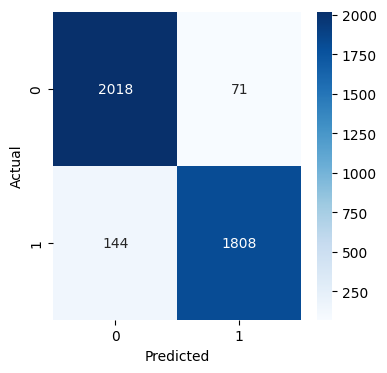

In [30]:
plt.figure(figsize = (4,4))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')

# Bi-Lstm

In [31]:
model_bilstm = Sequential()
model_bilstm.add(Embedding(max_words, 128, input_length=maxlen))
model_bilstm.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model_bilstm.add(Dense(2, activation='sigmoid'))

In [32]:
model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
model_bilstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 128)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 739,074
Trainable params: 739,074
Non-trainable params: 0
_________________________________________________________________


In [34]:
model_bilstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
253/253 [==============================] - 280s 1s/step - loss: 0.2628 - accuracy: 0.8912 - val_loss: 0.1538 - val_accuracy: 0.9416
Epoch 2/5
253/253 [==============================] - 266s 1s/step - loss: 0.1032 - accuracy: 0.9647 - val_loss: 0.1418 - val_accuracy: 0.9500
Epoch 3/5
253/253 [==============================] - 263s 1s/step - loss: 0.0614 - accuracy: 0.9806 - val_loss: 0.1438 - val_accuracy: 0.9498
Epoch 4/5
253/253 [==============================] - 263s 1s/step - loss: 0.0355 - accuracy: 0.9877 - val_loss: 0.1566 - val_accuracy: 0.9503
Epoch 5/5
253/253 [==============================] - 261s 1s/step - loss: 0.0268 - accuracy: 0.9916 - val_loss: 0.1884 - val_accuracy: 0.9493


In [35]:
y_pred2 = model_bilstm.predict(X_test)
y_pred2 = [1 if x[1]>0.5 else 0 for x in y_pred2]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test.iloc[:,1], y_pred2))
print('Classification Report:')
print(classification_report(y_test.iloc[:,1], y_pred2))

127/127 [==============================] - 9s 71ms/step
Accuracy: 0.949517446176689
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      2089
           1       0.95      0.94      0.95      1952

    accuracy                           0.95      4041
   macro avg       0.95      0.95      0.95      4041
weighted avg       0.95      0.95      0.95      4041



In [36]:
cm_cv = confusion_matrix(y_test.iloc[:,1],y_pred2)
cm_cv

array([[1996,   93],
       [ 111, 1841]])

In [37]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

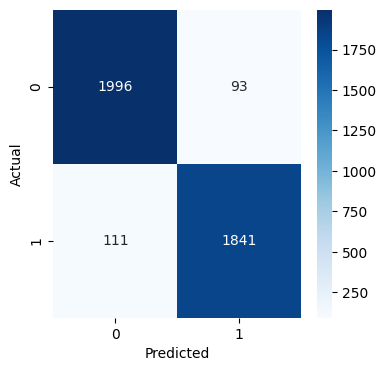

In [38]:
plt.figure(figsize = (4,4))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')